In [1]:
%load_ext autoreload

%autoreload 2
import matplotlib.pyplot as plt
import pickle
from astropy.coordinates import SkyCoord, match_coordinates_3d, match_coordinates_sky
import sys
import emcee
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.table import Table, QTable, hstack, vstack
from astropy import units as u
import corner
from astropy.coordinates import SkyCoord, match_coordinates_3d
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
import iminuit
from iminuit import Minuit
cosmo_astropy.critical_density(0.4).to(u.Msun / u.Mpc**3).value

sys.path.append('/pbs/throng/lsst/users/cpayerne/CLMassDC2/modules/')
import CL_WL_miscentering as mis
import analysis_Mass_Richness_relation as analysis
import CL_WL_two_halo_term as twoh
import CL_WL_mass_conversion as utils
import CL_DATAOPS_match_catalogs as match
import CL_WL_DATAOPS_make_profile as prf
import CL_Likelihood_for_Mass_richness_relation_v1 as mass_richness
import CL_WL_fit_cluster_mass_v1 as fit
#import CL_fiducial_mass_richness_relation as fiducial
#import analysis_Mass_richness_relation as analysis


import clmm
import clmm.dataops
from clmm.dataops import compute_tangential_and_cross_components, make_radial_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as u
import astropy.units as un
from clmm import Cosmology
from clmm.support import mock_data as mock
import pyccl as ccl

cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_ccl  = ccl.Cosmology(Omega_c=0.265-0.0448, Omega_b=0.0448, h=0.71, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)

In [2]:
def load(filename, **kwargs):
    with open(filename, 'rb') as fin:
        return pickle.load(fin, **kwargs)

In [3]:
ind_profile = np.load('../data/data_new_version/ind_profile_redmapper.pkl', allow_pickle = True)
ind_profile['cluster_id'] = ind_profile['id']

In [4]:
sum_weights_per_cluster_10 = []
sum_weights_per_cluster_5 = []
for i, cl in enumerate(ind_profile):
    mask = (ind_profile['radius_true'][i] > 1)*(ind_profile['radius_true'][i] < 10)
    sum_weights_per_cluster_10.append(np.sum(ind_profile['W_l_true'][i][mask]))
    mask = (ind_profile['radius_true'][i] > 1)*(ind_profile['radius_true'][i] < 5.5)
    sum_weights_per_cluster_5.append(np.sum(ind_profile['W_l_true'][i][mask]))

In [5]:
ind_profile['weight_per_cluster_5'] = np.array(sum_weights_per_cluster_5)*1e27
ind_profile['weight_per_cluster_10'] = np.array(sum_weights_per_cluster_10)*1e27

In [6]:
Z_bin = analysis.Z_bin
Obs_bin = analysis.Obs_bin
Gamma_5 = 0.75
Gamma_10 = 0.8

In [7]:
z_max = max(Z_bin[-1])
z_min = min(Z_bin[0])
obs_min = min(Obs_bin[0])
obs_max = max(Obs_bin[-1])

In [8]:
z_min

0.2

# WL masses

## WL shear profiles

In [9]:
profile_sky_stack = prf.stacked_profile(profile = ind_profile,
                    r_in = 'radius_true',
                    gt_in = 'DSt_true', gx_in = 'DSx_true',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'W_l_true',
                    z_name = 'redshift', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin,
                    add_columns_to_bin = ['weight_per_cluster_10','weight_per_cluster_5', 'richness', 'redshift'])

covariance_sky_stack = prf.bootstrap_covariance(profile = ind_profile,
    r_in = 'radius_true',
                    gt_in = 'DSt_true', gx_in = 'DSx_true',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'W_l_true',
                    n_boot = 400,
                    z_name = 'redshift', obs_name = 'richness',
                    Z_bin = Z_bin, Obs_bin = Obs_bin)

## Fit WL masses

In [10]:
%load_ext autoreload
%autoreload 2
import CL_WL_fit_cluster_mass_v1 as fit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
#fix_c_Diemer15 =       fit.fit_WL_cluster_mass(profile = profile_sky_stack, covariance = covariance_sky_stack, a = 0, b = 1, rmax = 5.5, two_halo_term = False, fix_c = True, mc_relation = 'Diemer15')
a = 0
b = 1
rmax = 5.5
fix_c_Duffy08 =        fit.fit_WL_cluster_mass(profile = profile_sky_stack, covariance = covariance_sky_stack, a = a, b = b, rmax = rmax, two_halo_term = False, fix_c = True, mc_relation = 'Duffy08')
#fix_c_Prada12 =        fit.fit_WL_cluster_mass(profile = profile_sky_stack, covariance = covariance_sky_stack, a = 0, b = 1, rmax = 5.5, two_halo_term = False, fix_c = True, mc_relation = 'Prada12')
#fix_c_Bhattacharya13 = fit.fit_WL_cluster_mass(profile = profile_sky_stack, covariance = covariance_sky_stack, a = 0, b = 1, rmax = 5.5, two_halo_term = False, fix_c = True, mc_relation = 'Bhattacharya13')
#free_c_1h =            fit.fit_WL_cluster_mass(profile = profile_sky_stack, covariance = covariance_sky_stack, a = 0, b = 1, rmax = 5.5, two_halo_term = False, fix_c = False)

fitting...


Text(0, 0.5, '$\\log_{10}(M_{\\rm 200c}^{\\rm WL}/M_{\\odot})$')

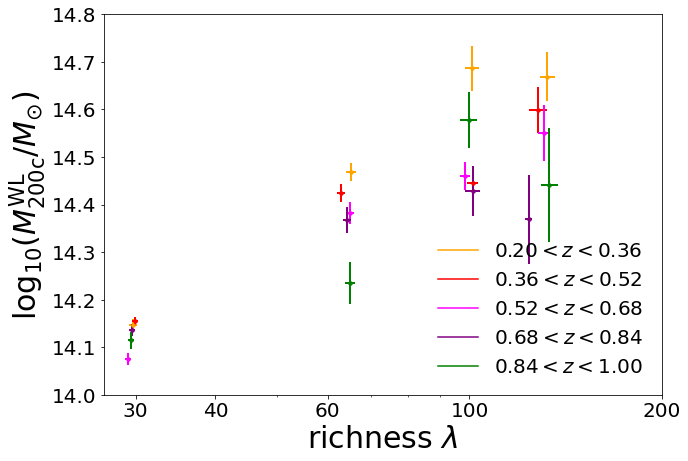

In [12]:
import matplotlib.ticker
fig, ax  = plt.subplots(figsize = (10,7))
color_z = ['orange','red','magenta','purple','green','cyan','blue','black']
x = np.linspace(1,3,100)
f = fix_c_Duffy08
for k, z_bin in enumerate(Z_bin):
        f = Table(f)
        plt.plot([],[], '-', c = color_z[k],label = f'{z_bin[0]:.2f}'+ r'$< z < $'+ f'{z_bin[1]:.2f}',)
        mask = (f['z_mean'] > z_bin[0])*(f['z_mean'] < z_bin[1])
        f_cut = f[mask]
        a_t = 1./(1 + f_cut['z_mean'])
        richness = f_cut['obs_mean']
        richness_err = f_cut['obs_rms']
        logm200w = f_cut['logm200_w']
        logm200w_err = f_cut['logm200_w_err']
        ax.errorbar(richness,logm200w,logm200w_err, richness_err,
                    marker = '.', fmt = ' ',
                    elinewidth = 2, capsize = 0, markersize = 7, c = color_z[k],
                        markerfacecolor = None)

ax.set_ylim(14,14.8)
ax.set_xscale('log')
ax.tick_params(axis='both', which = 'major', labelsize= 20)
ax.set_xticks([30,40, 60, 100, 200])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.legend(frameon = False, fontsize = 20, loc = 'lower right')
ax.set_xlabel(r'richness $\lambda$', fontsize = 30)
ax.set_ylabel(r'$\log_{10}(M_{\rm 200c}^{\rm WL}/M_{\odot})$', fontsize = 30)
#plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/est_mass_validation_free_c_1h.png', bbox_inches='tight', dpi=300)
#plt.show()

# WL Mass-richness relation

## first approach

In [13]:
lnL = mass_richness.WL_Mass_Richness()

In [14]:
z0 = analysis.z0
richness0 = analysis.richness0
initial_binned = [14.1,-1,.75]
npath = 200
ndim=3
nwalkers = 200
pos_binned = initial_binned + 0.01 * np.random.randn(nwalkers, len(initial_binned))
label = [r'$M_{\rm wl}$',r'$M_{\rm wl}+w$',r'$M_{\rm wl}+w+\Gamma$']
sampler_list = {}
w = ['lensing', 'lensing','lensing']
Gamma = [Gamma_5, Gamma_5, Gamma_5]
fits = [fix_c_Duffy08,fix_c_Duffy08,fix_c_Duffy08]
for i,fit_true in enumerate(fits):
    
    fit_true = fit_true[fit_true['z_mean'] < .8]
    
    if w[i]=='nlensing':
        wused = fit_true['weight_per_cluster_5']*0 + 1
    else: wused = fit_true['weight_per_cluster_5']
    
    lnL = mass_richness.WL_Mass_Richness(logm=fit_true['logm200_w'], logm_err=fit_true['logm200_w_err'], 
                 richness=fit_true['obs_mean'], richness_err=None, 
                 z=fit_true['z_mean'], z_err=None,
                 richness_individual=fit_true['richness'], 
                 z_individual=fit_true['redshift'], 
                 n_cluster_per_bin=None, weights_individual=wused)
    lnL.scatter_logm = [0.14**.5/np.log(10),0][i]
    print(lnL.scatter_logm)
    lnL.set_pivot_values(z0, richness0)
    lnL.Gamma = Gamma[i]
    from multiprocessing import Pool
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnL.lnLikelihood_individual_zrichness, pool=pool)
        sampler.run_mcmc(pos_binned, npath,progress=True)
    sampler_wl = sampler.get_chain(discard = 0, flat = True)
    sampler_list[label[i]] = sampler_wl
    #break

0.1624981156248464


100%|██████████| 200/200 [00:53<00:00,  3.76it/s]

0



100%|██████████| 200/200 [00:51<00:00,  3.86it/s]


IndexError: list index out of range

In [ ]:
plt.plot(sampler_list[r'$M_{\rm wl}$'][:,1])

In [ ]:
plt.rcParams['axes.linewidth'] = 1.3
labels_param = [r'$\log_{10}(M_{0})$', r'$G_z$',r'$F_\lambda$']
sigma1 = 1. - np.exp(-(1./1.)**2/2.)
sigma2 = 1. - np.exp(-(2./1.)**2/2.)
sigma3 = 1. - np.exp(-(3./1.)**2/2.)
truth = [14.162, -0.23, 0.8]
bins = 15
c = ['r', 'orange', 'salmon', 'k', 'b', 'g']
fill_contours = [False, False,False, False,  False, False]
dashed = ['solid','solid','solid', 'dashed', 'solid', 'solid']
fig, axs = plt.subplots(3,3, figsize = (7,7))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=10, hspace=0)
#for i, name in enumerate(label_plot):
#    axs[0,2].plot([],[], c[i], linewidth = 10, label = label_plot[i])

for i,sample in enumerate(sampler_list):
    #if np.isin(sample, [r'$M_{\rm wl}$ + scatter']):
    #    continue
    sample = sampler_list[sample]
    print(sample.shape)
    a = len(sample)
    print(a)
    sample_cut = sample[35000:a-1]
    fig = corner.corner(
    sample_cut,
    bins=bins, levels=(sigma1, sigma2),
        #truths = fiducial_constraint,
    
    #range = range_corner_plot,
    fig = fig,
    color = c[i],
        ls = '--',
    smooth1d=True,smooth=True,plot_datapoints=False,
    fill_contours=fill_contours[i], labels = labels_param,            
    label_kwargs={"fontsize": 20},
    use_math_text=True,
    show_title = True,
    plot_density=False,
    max_n_ticks = 5, 
    contour_kwargs={'linestyles':dashed[i], 'linewidths':2})
axs[0,2].legend(frameon = True, fontsize = 15, loc = 'upper right')
for i in range(3):
    for j in range(3):
        axs[i,j].tick_params(axis='both', which = 'major', labelsize= 10)
       # if i == j:
           # axs[i,j].set_ylim(0,500)

#plt.savefig('effect_modelling_likelihood_consideration.png', bbox_inches='tight', dpi=300)

## Second approach

In [ ]:
prf_truncated = []
inv_cov_truncated = []
radius_truncated = []
z = []
richness = []
for halo, cov in zip(profile_sky_stack, covariance_sky_stack):
    if (halo['z_mean'] > .8): continue

    z.append(halo['z_mean'])
    richness.append(halo['obs_mean'])
    mask = (halo['radius'] > b)*(halo['radius'] < rmax)
    prf_truncated.append(halo['gt'][mask])
    radius_truncated.append(halo['radius'][mask])
    index_cut=np.arange(len(halo['radius']))[mask]
    cov_tr = np.array([np.array([cov['cov_t'][i,j] for i in index_cut]) for j in index_cut])
    #inv_cov_truncated.append(np.linalg.inv(cov_tr))
    inv_cov_truncated.append(np.linalg.inv(np.diag(cov_tr.diagonal())))

In [ ]:
moo=clmm.Modeling(massdef = 'critical', delta_mdef = 200, halo_profile_model = 'nfw')
moo.set_cosmo(cosmo_clmm)
deff = ccl.halos.massdef.MassDef(200, 'critical', c_m_relation=None)
concDiemer15 = ccl.halos.concentration.ConcentrationDiemer15(mdef=deff)
concDuffy08 = ccl.halos.concentration.ConcentrationDuffy08(mdef=deff)
concPrada12 = ccl.halos.concentration.ConcentrationPrada12(mdef=deff)
concBhattacharya13 = ccl.halos.concentration.ConcentrationBhattacharya13(mdef=deff)

In [ ]:
def ds(r, m, c, z):
    moo.set_mass(m), moo.set_concentration(c)
    y=moo.eval_excess_surface_density([float(r[i]) for i in range(len(r))], z)
    return y

In [ ]:
0.3/np.log(10)

In [ ]:
import time

In [ ]:
str(time.time())

In [ ]:
lnL.set_pivot_values(z0, richness0)
def lnlikelihood_from_shear_profile(theta1):
    logM0,G,F, sigma_int = theta1
    theta = logM0,G,F
    chi2=0
    if sigma_int < 0:# or sigma_int > .2:
        return -np.inf
    if logM0 < 11: return -np.inf
    np.random.seed(int(abs(194709*np.prod(theta1))))
    #np.random.shuffle(u)
    u = np.random.randn(100)
   # print(' stop '+str(u[0]))
    #print([u1, u2])
    for n, halo in enumerate(prf_truncated):
        mu_lnm = lnL.mu_logM_lambda(richness[n], z[n], theta)
        
        sigma_lnm = np.sqrt(sigma_int**2 + F**2/(richness[n]))
        
        ln_m = mu_lnm + sigma_lnm**2/2 + sigma_lnm*u

        lnc = np.log(concDuffy08._concentration(cosmo_ccl, np.exp(ln_m), 1./(1. + z[n]))) + 0.2*u
        c = np.exp(lnc)
        
        ds_table = np.zeros([len(u), len(radius_truncated[n])])
        
        for i in range(len(u)):
            ds_table[i,:] = ds(radius_truncated[n], np.exp(ln_m[i]), c[i], z[n])
    
        #y=ds(radius_truncated[n], 10**log10m, c, z[n])
        #ds_mean = ds(radius_truncated[n], np.exp(ln_mu_m), c, z[n])#
        ds_mean = np.mean(ds_table, axis=0)
        delta = halo-ds_mean
        chi2+=.5*np.sum(delta*inv_cov_truncated[n].dot(delta))
    return -chi2

In [ ]:
lnlikelihood_from_shear_profile([14.32, -1, 1, .1 ])

In [ ]:
pos_binned = [14.1, -.4, .7, .1] + 0.1 * np.random.randn(100, 4)
lnL.set_pivot_values(z0, richness0)
from multiprocessing import Pool
with Pool(10) as pool:
    sampler = emcee.EnsembleSampler(100, 4, lnlikelihood_from_shear_profile, pool=pool,)
    sampler.run_mcmc(pos_binned, 100,progress=True)
sampler_wl = sampler.get_chain(discard = 0, flat = True)

In [ ]:
plt.plot(sampler_wl[:,0])

In [ ]:
k = sampler_wl
a = len(k)
middle = np.mean(k[8000:a-1], axis = 0)
std = np.std(k[8000:a-1], axis = 0)
range_corner_plot = [(middle[i]- 2*std[i], middle[i]+ 2*std[i]) for i in range(4)]

In [ ]:
range_corner_plot

In [ ]:
sigma1 = 1. - np.exp(-(1./1.)**2/2.)
sigma2 = 1. - np.exp(-(2./1.)**2/2.)
sigma3 = 1. - np.exp(-(3./1.)**2/2.)
truth = [14.4, -0.23, 0.8]
bins = 10
c = ['k', 'b', 'r', 'k', 'b', 'g']
fill_contours = [False, False,False, False,  False, False]
dashed = ['solid','solid','solid', 'dashed', 'solid', 'solid']
fig, axs = plt.subplots(4,4, figsize = (7,7))
fig=corner.corner(sampler_wl[(sampler_wl[:,3]>0)*(sampler_wl[:,3]<0.4)][5000:][::3], bins=10
                  , smooth=True,
                  truths=[14.085413538879381, -0.28053966354593196 ,0.783988802896054, .4/np.log(10) ],
                  color='red',
                  plot_datapoints=True,smooth1d=False, #plot_density=False,
                  labels = ['logM', 'G', 'F', 'sigma'], fig=fig, levels=[sigma1, sigma2], contour_kwargs={ 'linestyles':'--', 'linewidths':2})

In [ ]:
for p in 

In [ ]:
k = sampler_list[r'$M_{\rm wl}$']
a = len(k)
middle = np.mean(k[19000:a-1], axis = 0)
std = np.std(k[19000:a-1], axis = 0)
range_corner_plot = [(middle[i]- 3.5*std[i], middle[i]+ 3.5*std[i]) for i in range(3)]

In [ ]:
plt.rcParams['axes.linewidth'] = 1.3
labels_param = [r'$\log_{10}(M_{0})$', r'$G_z$',r'$F_\lambda$']
sigma1 = 1. - np.exp(-(1./1.)**2/2.)
sigma2 = 1. - np.exp(-(2./1.)**2/2.)
sigma3 = 1. - np.exp(-(3./1.)**2/2.)
truth = [14.162, -0.23, 0.8]
bins = 10
c = ['k', 'b', 'r', 'k', 'b', 'g']
fill_contours = [False, False,False, False,  False, False]
dashed = ['solid','solid','solid', 'dashed', 'solid', 'solid']
fig, axs = plt.subplots(3,3, figsize = (7,7))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=10, hspace=0)
#for i, name in enumerate(label_plot):
#*    axs[0,2].plot([],[], c[i], linewidth = 10, label = label_plot[i])

for i,sample in enumerate(sampler_list):
    #if np.isin(sample, [r'$M_{\rm wl}$ + scatter']):
    #    continue
    sample = sampler_list[sample]
    print(sample.shape)
    a = len(sample)
    print(a)
    sample_cut = sample[19000:a-1]
    fig = corner.corner(
    sample_cut,
    bins=bins, levels=(sigma1, sigma2),
        #truths = fiducial_constraint,
    
    #range = range_corner_plot,
    fig = fig,
    color = c[i],
        ls = '--',
    smooth1d=True,smooth=True,plot_datapoints=False,
    fill_contours=fill_contours[i], labels = labels_param,            
    label_kwargs={"fontsize": 20},
    use_math_text=True,
    show_title = True,
    plot_density=False,
    max_n_ticks = 5, 
    contour_kwargs={'linestyles':dashed[i], 'linewidths':2})
axs[0,2].legend(frameon = True, fontsize = 15, loc = 'upper right')
for i in range(3):
    for j in range(3):
        axs[i,j].tick_params(axis='both', which = 'major', labelsize= 10)
       # if i == j:
           # axs[i,j].set_ylim(0,500)

#plt.savefig('effect_modelling_likelihood_consideration.png', bbox_inches='tight', dpi=300)

In [ ]:
import emcee
from multiprocessing import Pool
n_walkers = 100
n_step = 100
start_walkers = [1,1,1] + 0.1 * np.random.randn(n_walkers, 3)
def lnL(p):
    u = np.random.random()
    #use u in the likelihood evaluation
    return ...
with Pool() as pool:
    sampler = emcee.EnsembleSampler(n_walkers 5, lnL, pool=pool, )
    sampler.run_mcmc(start_walkers, n_step,progress=True)
sampler = sampler.get_chain(discard = 0, flat = True)